In [1]:
pwd

'/Users/james/JWSTdata/W39_ERS/video_tutorial/MAST_2023-03-13T1032/JWST'

Opening some files to look at them

In [2]:
%matplotlib nbagg

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [24]:
f1 = fits.open("jw01366004001_04101_00001-seg001_nrs2/jw01366004001_04101_00001-seg001_nrs2_uncal.fits")

In [25]:
f1.info()

Filename: jw01366004001_04101_00001-seg001_nrs2/jw01366004001_04101_00001-seg001_nrs2_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     197   ()      
  1  SCI           1 ImageHDU        67   (512, 32, 5, 6100)   int16 (rescales to uint16)   
  2  GROUP         1 BinTableHDU     38   122R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  3  INT_TIMES     1 BinTableHDU     24   6100R x 7C   [J, D, D, D, D, D, D]   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [8049B]   


In [26]:
f1["SCI"].shape

(6100, 5, 32, 512)

In this segment there are 6100 integrations of 5 groups. There are 32 rows and 512 cols

In [27]:
nints,ngroups,nrows,ncols = f1["SCI"].shape

Create a median science image from the final group of every integration

In [28]:
f1_science = np.median([f1["SCI"].data[i][ngroups-1] for i in range(nints)],axis=0)

In [29]:
f1_science.shape

(32, 512)

OK, that has the expected shape of a single image with 32 rows and 512 columns. Now let's plot these.

<IPython.core.display.Javascript object>


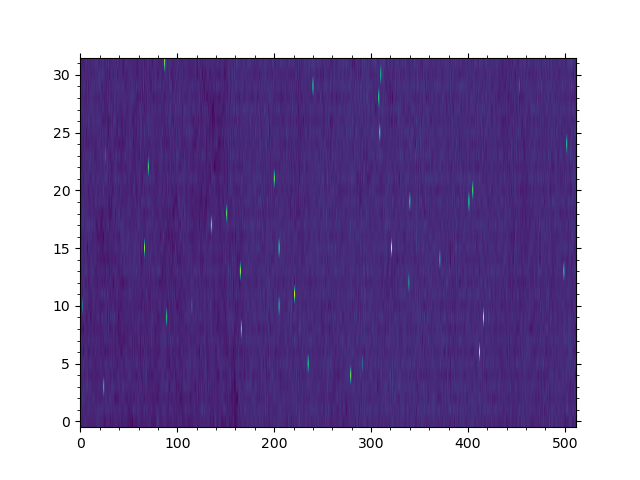

In [30]:
vmin,vmax = np.percentile(f1_science,[10,90])
plt.figure()
plt.imshow(f1_science,aspect="auto")#,vmin=vmin,vmax=vmax)
# plt.imshow(f1["SCI"].data[0][5])
plt.show()

OK, there are a few bad pixels here but also there's an odd background region at the top which might throw off a 1/f correction. I might want to make a narrower background region for the 1/f correction (not using full detector width).

In [12]:
from reduction_utils import cosmic_removal as c

In [13]:
help(c.flag_bad_pixels)

Help on function flag_bad_pixels in module reduction_utils.cosmic_removal:

flag_bad_pixels(frame, cut_off=5, max_pixels_per_row=10, plot_rows=None, use_mad=False, verbose=False, mf_box_width=3)
    A function that performs a row-by-row running median to locate bad pixels in a given frame.
    
    Inputs:
    frame - the (nrows,ncols) frame of image data under consideration
    cut_off - the sigma/mad clip at which outliers are flagged. Default=5 (5 sigma)
    max_pixels_per_row - the maximum number of bad pixels in a row to consider. If the number of flagged pixels is greater than this number, it's assumed something went wrong and no pixels are flagged for this row. Default=10
    plot_rows - give a list of rows at which the running median will be plotted. If not given, then no running median will be plotted. Default=None.
    use_mad - True/False - use the running median rather than the standard deviation of the residuals to flag outliers? Default=False
    verbose - True/False - if

In [14]:
np.median(n1_science)

13463.5

In [15]:
from scipy.signal import medfilt
from astropy.stats import median_absolute_deviation
mf_box_width = 5

median = np.array([medfilt(row,mf_box_width) for row in n1_science]) # running over 3 pixels
residuals = median - n1_science

cut_off = 10

good_pixels = ((residuals <= cut_off*median_absolute_deviation(residuals,ignore_nan=True)) & (residuals >= -cut_off*median_absolute_deviation(residuals,ignore_nan=True)))

good_pixels

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

/var/folders/xl/rnnh5p8s2077d5172fw8_lzm0000gn/T/ipykernel_24774/3157707795.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<IPython.core.display.Javascript object>


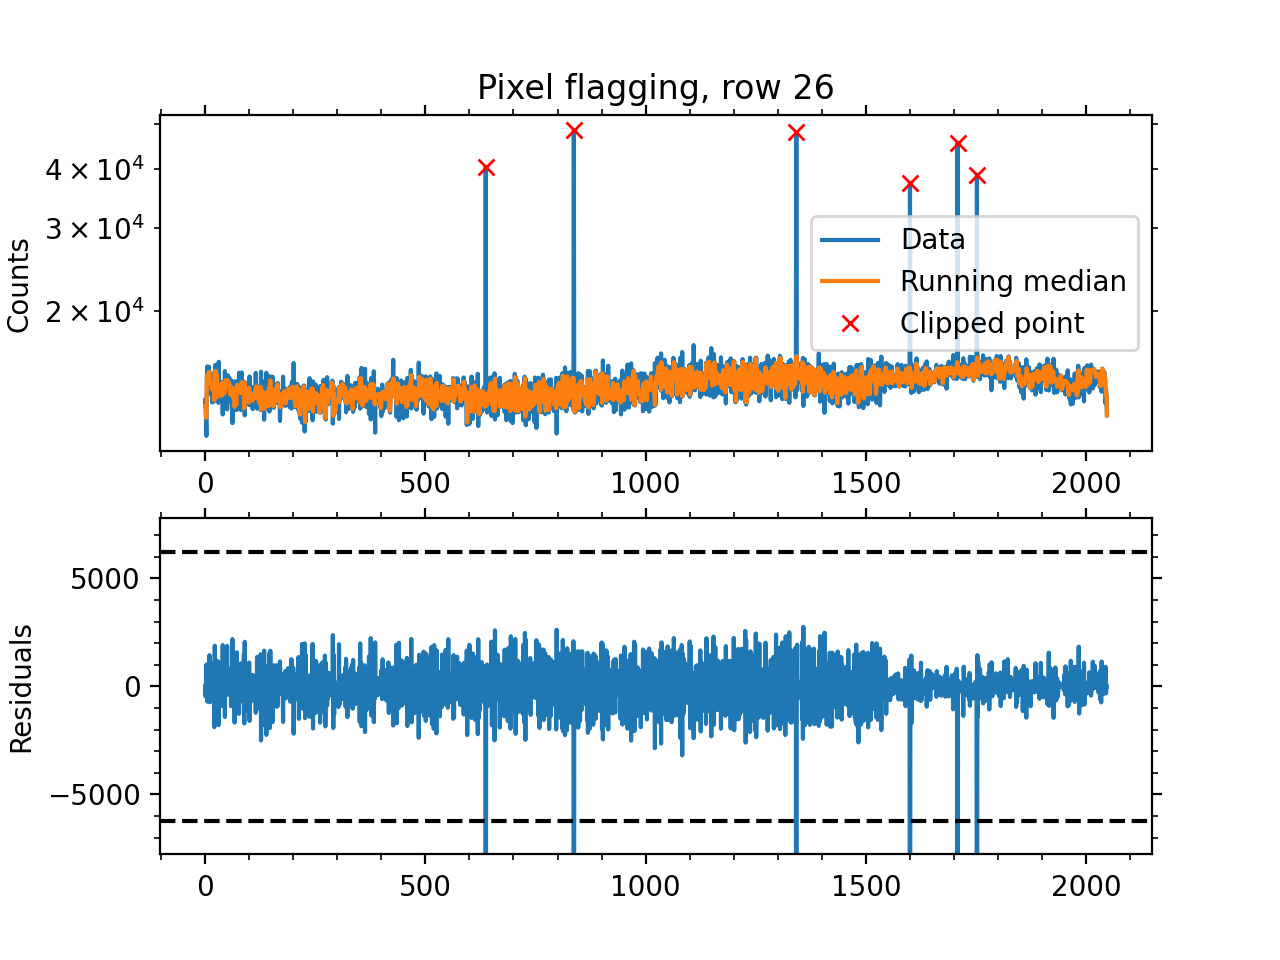

<IPython.core.display.Javascript object>


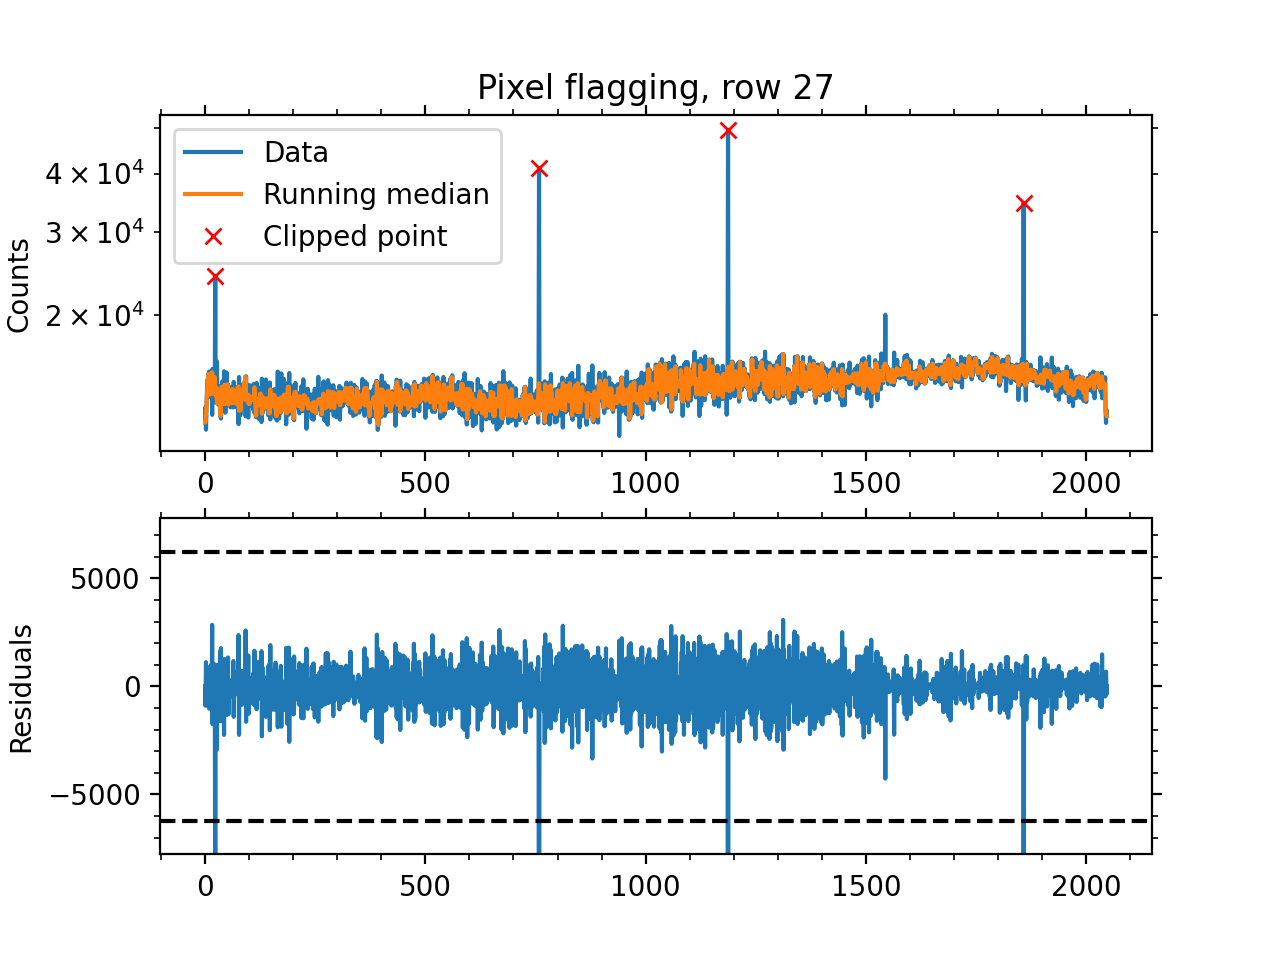

<IPython.core.display.Javascript object>


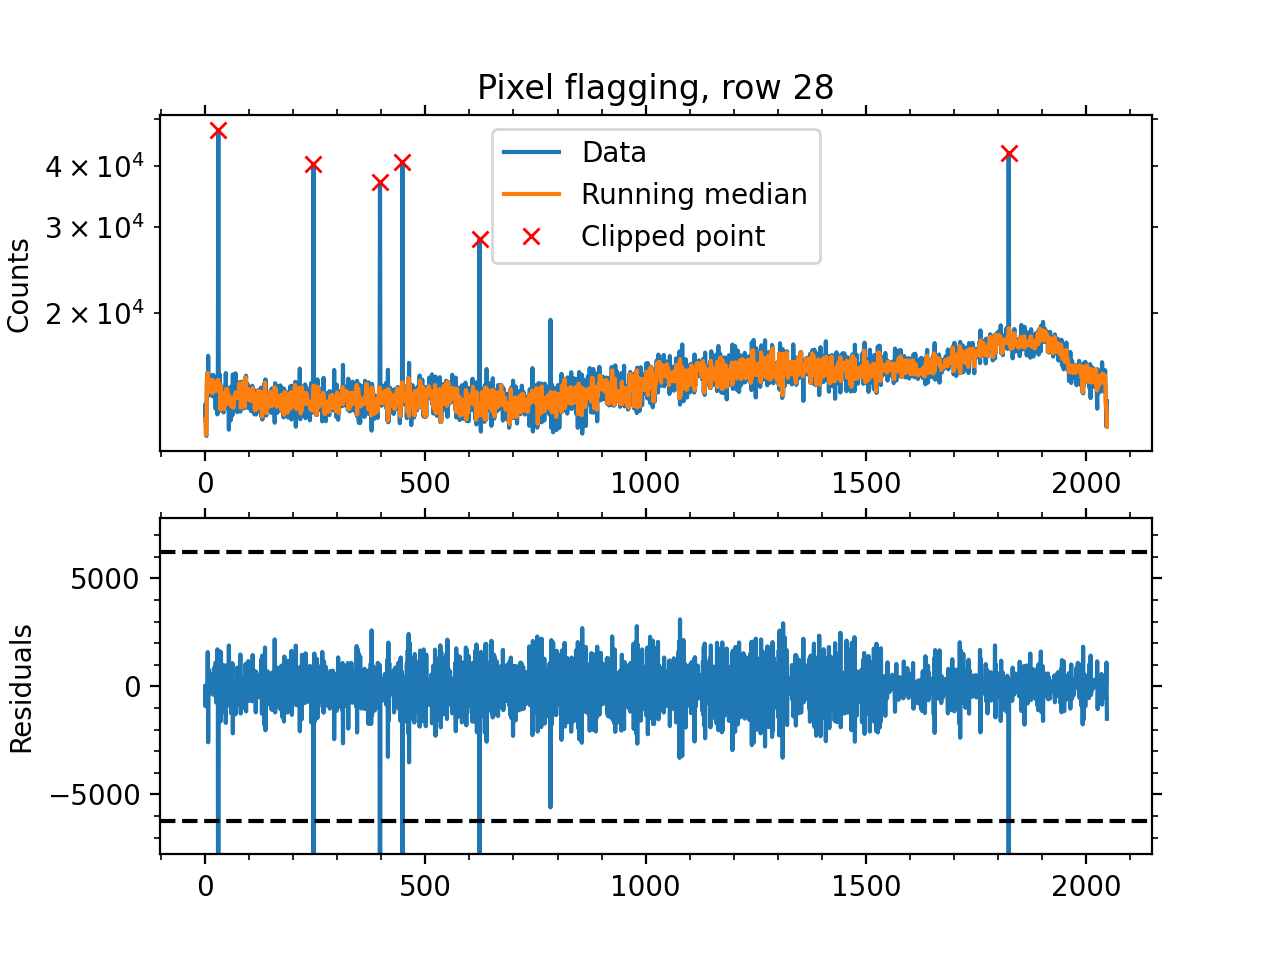

<IPython.core.display.Javascript object>


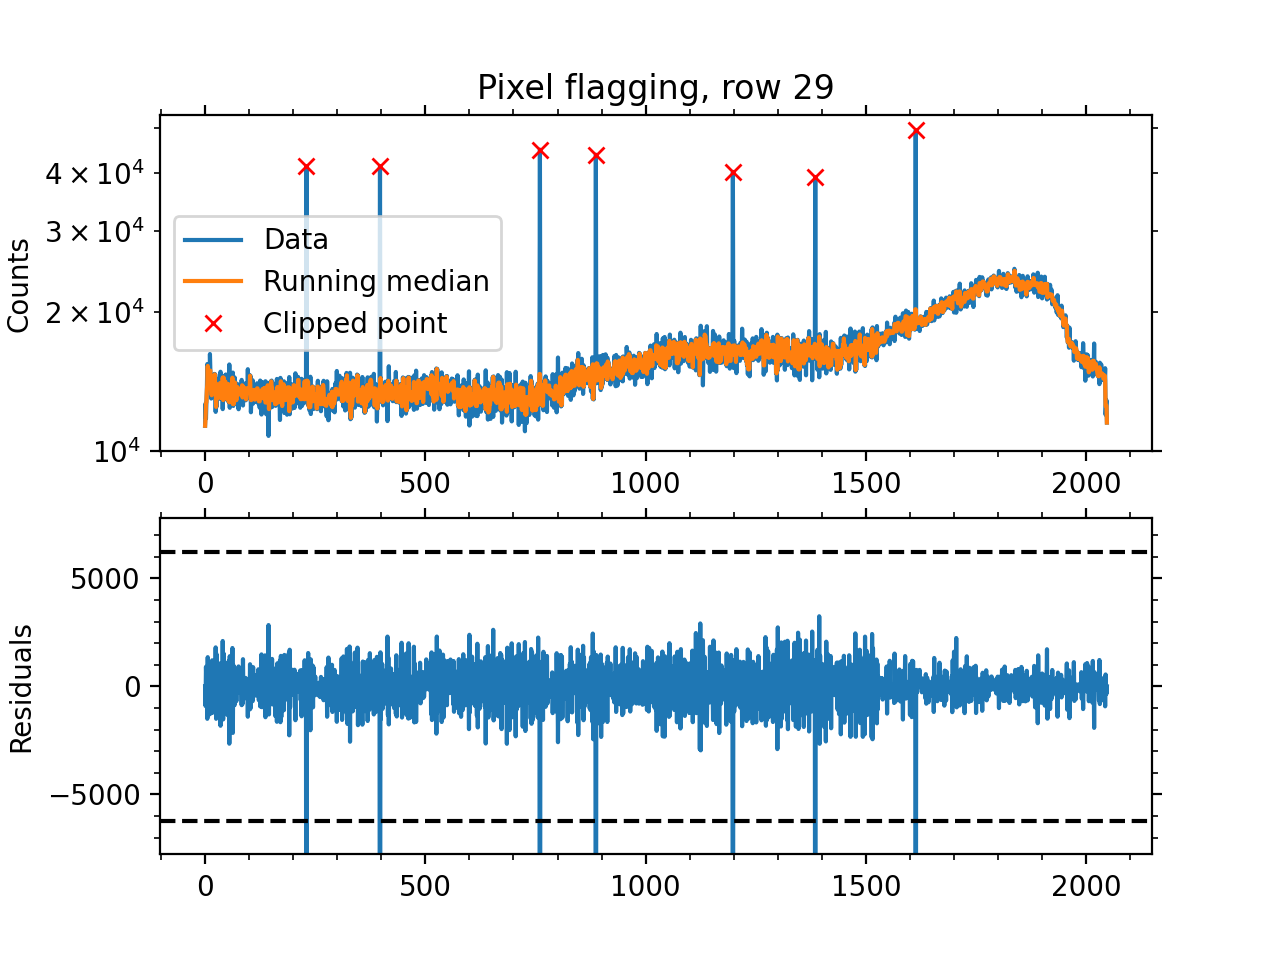

<IPython.core.display.Javascript object>


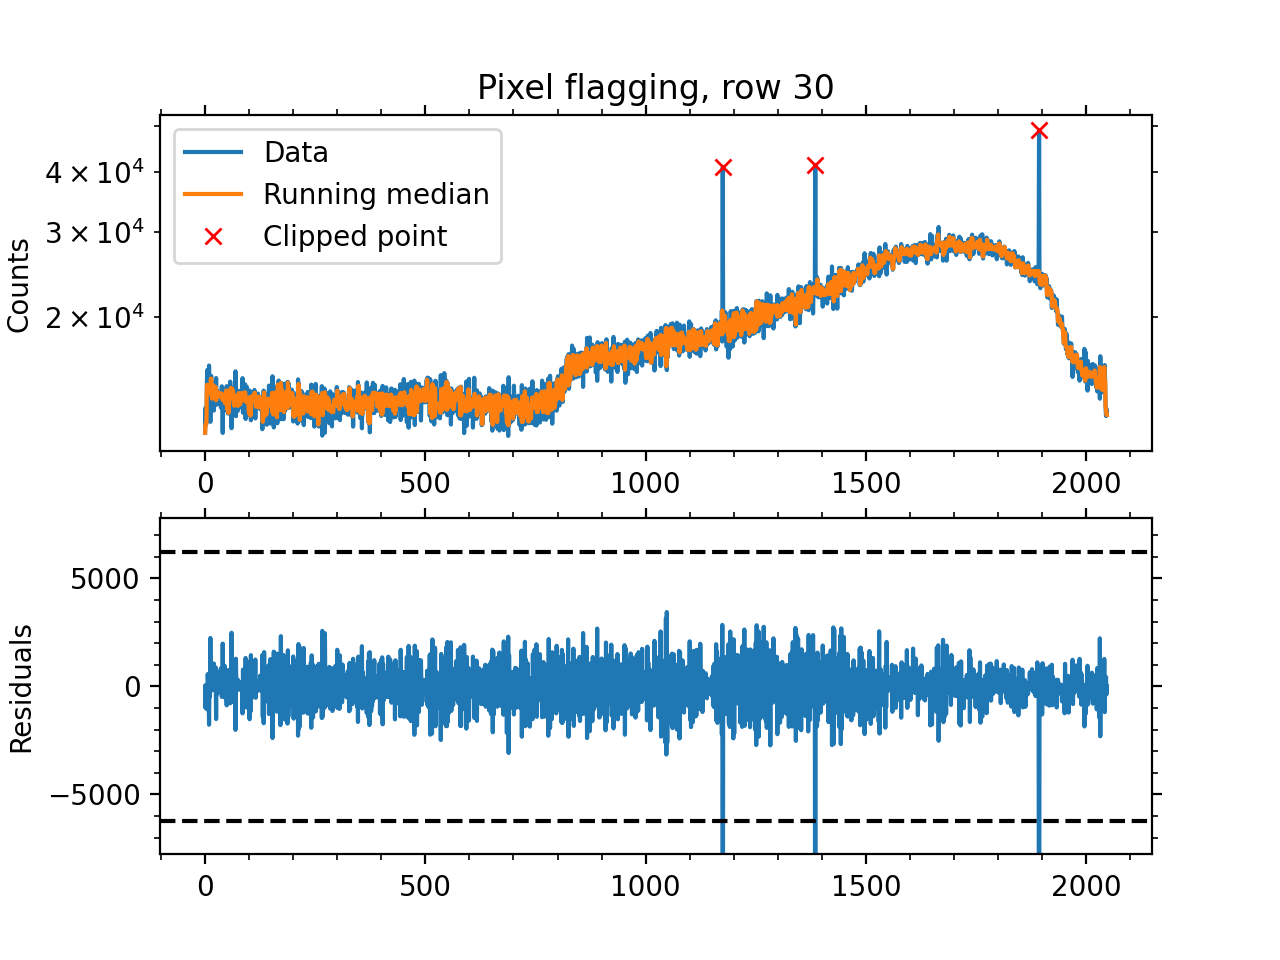

<IPython.core.display.Javascript object>


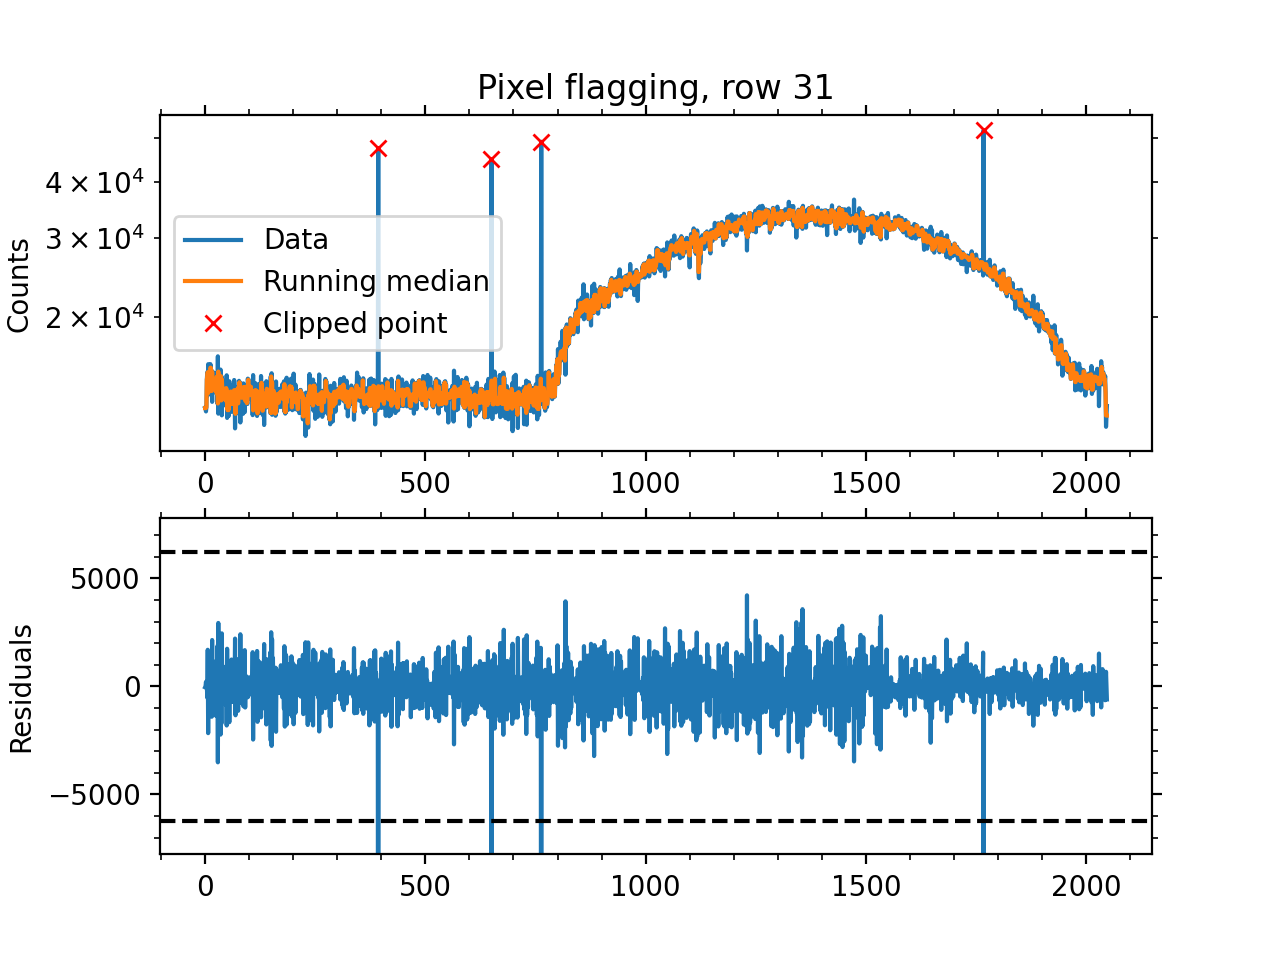

<IPython.core.display.Javascript object>


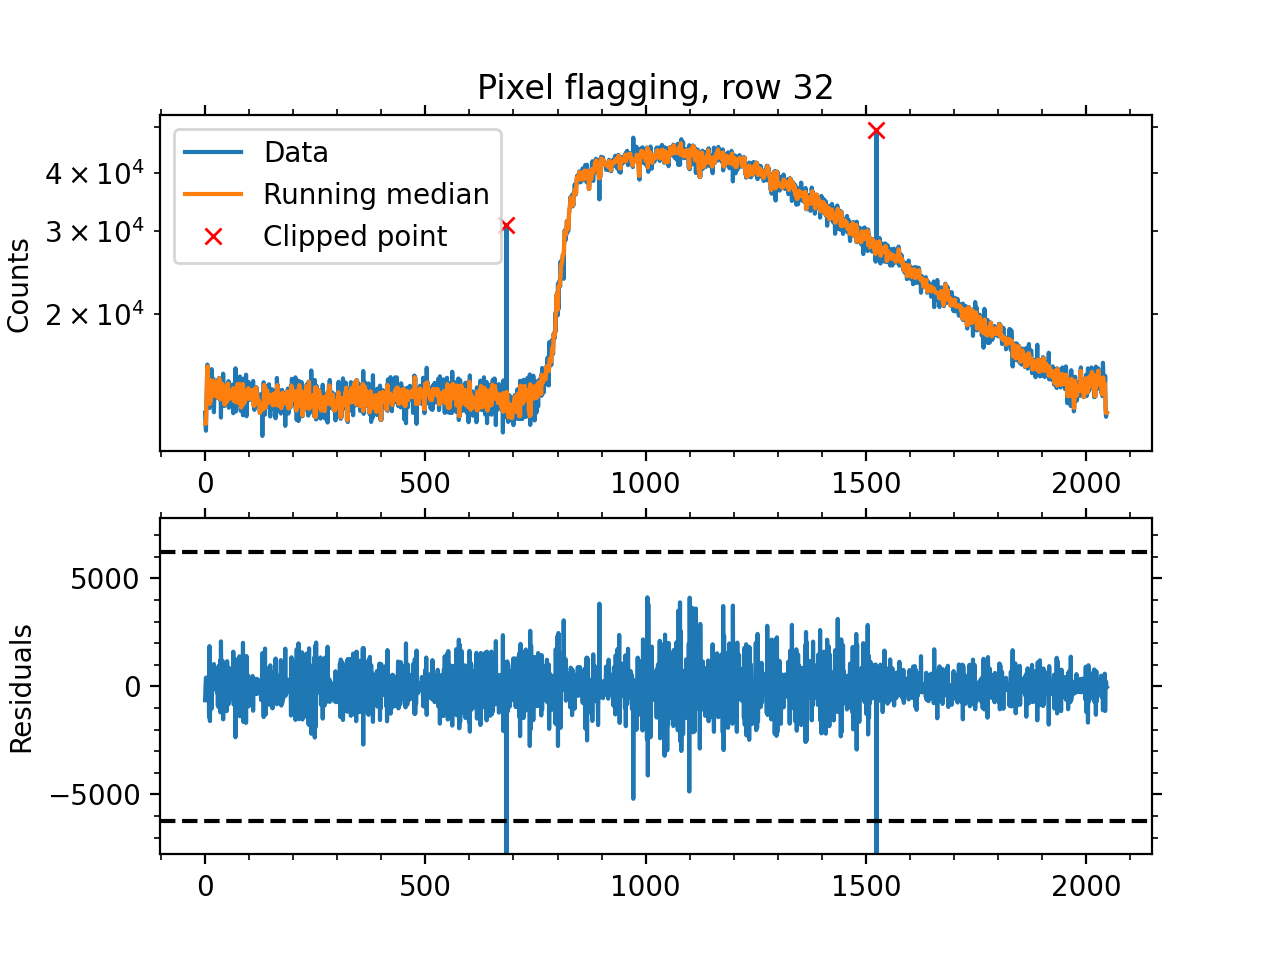

<IPython.core.display.Javascript object>


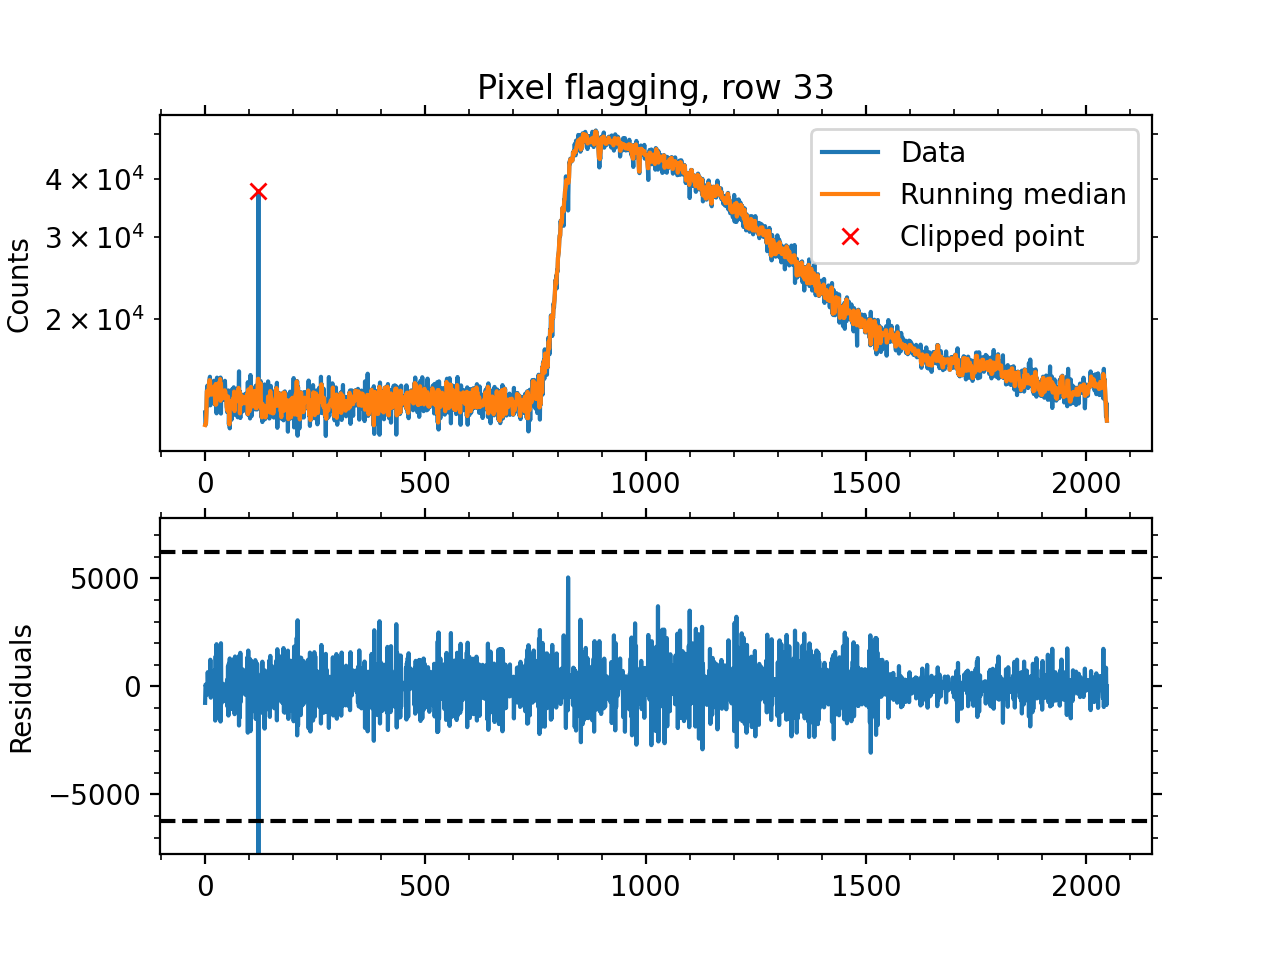

<IPython.core.display.Javascript object>


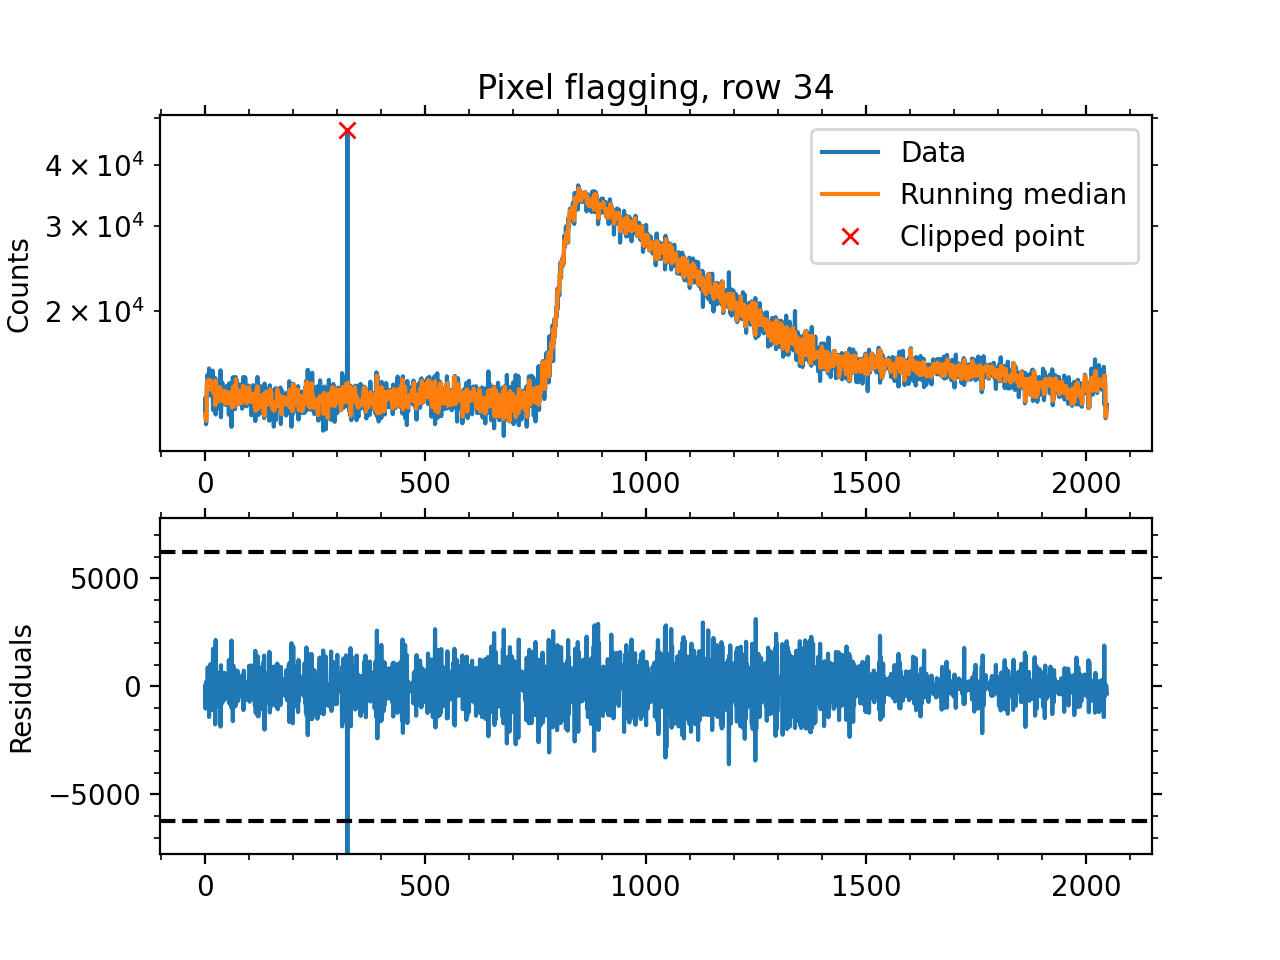

<IPython.core.display.Javascript object>


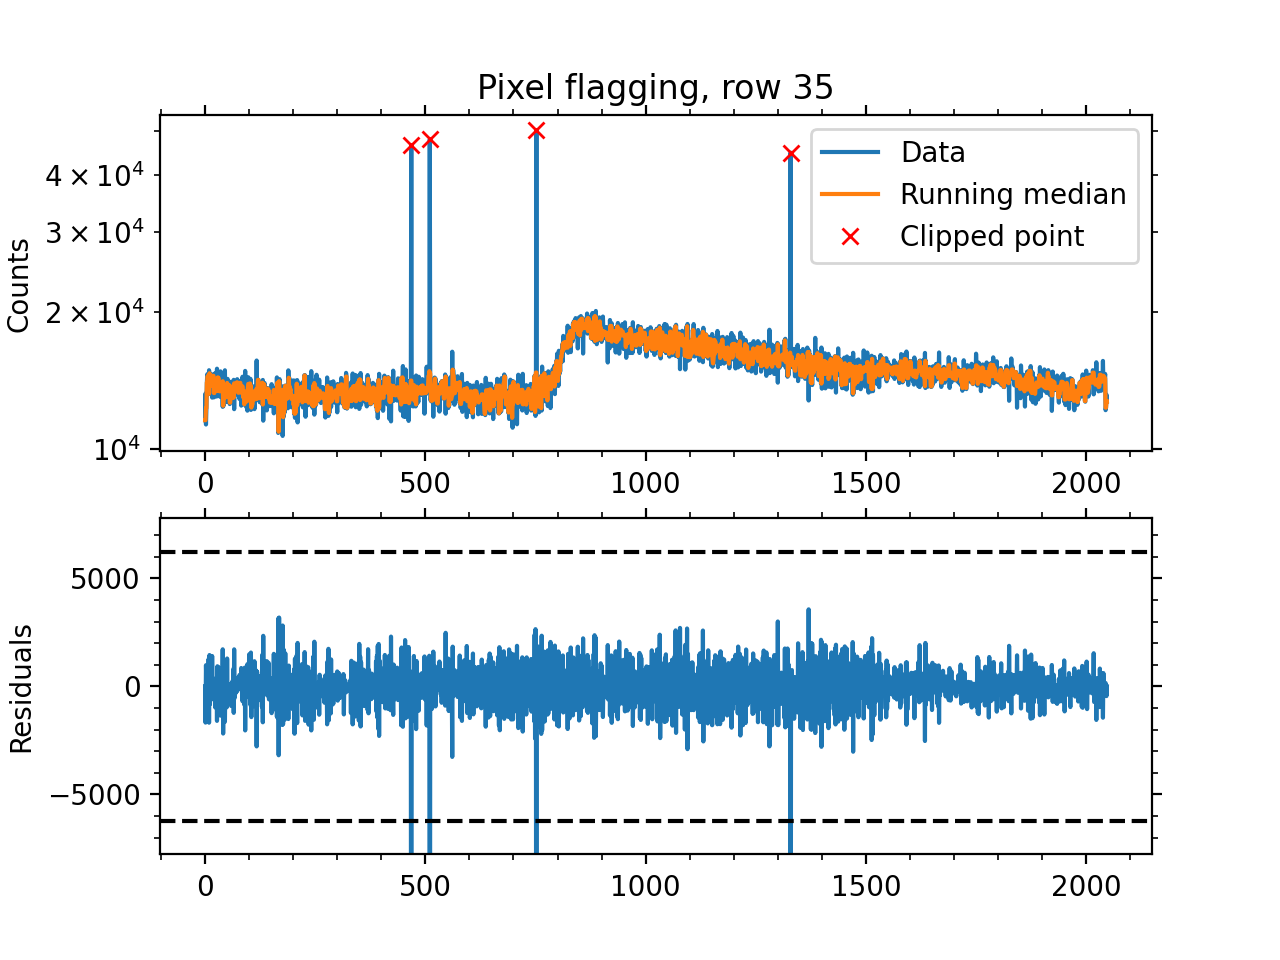

<IPython.core.display.Javascript object>


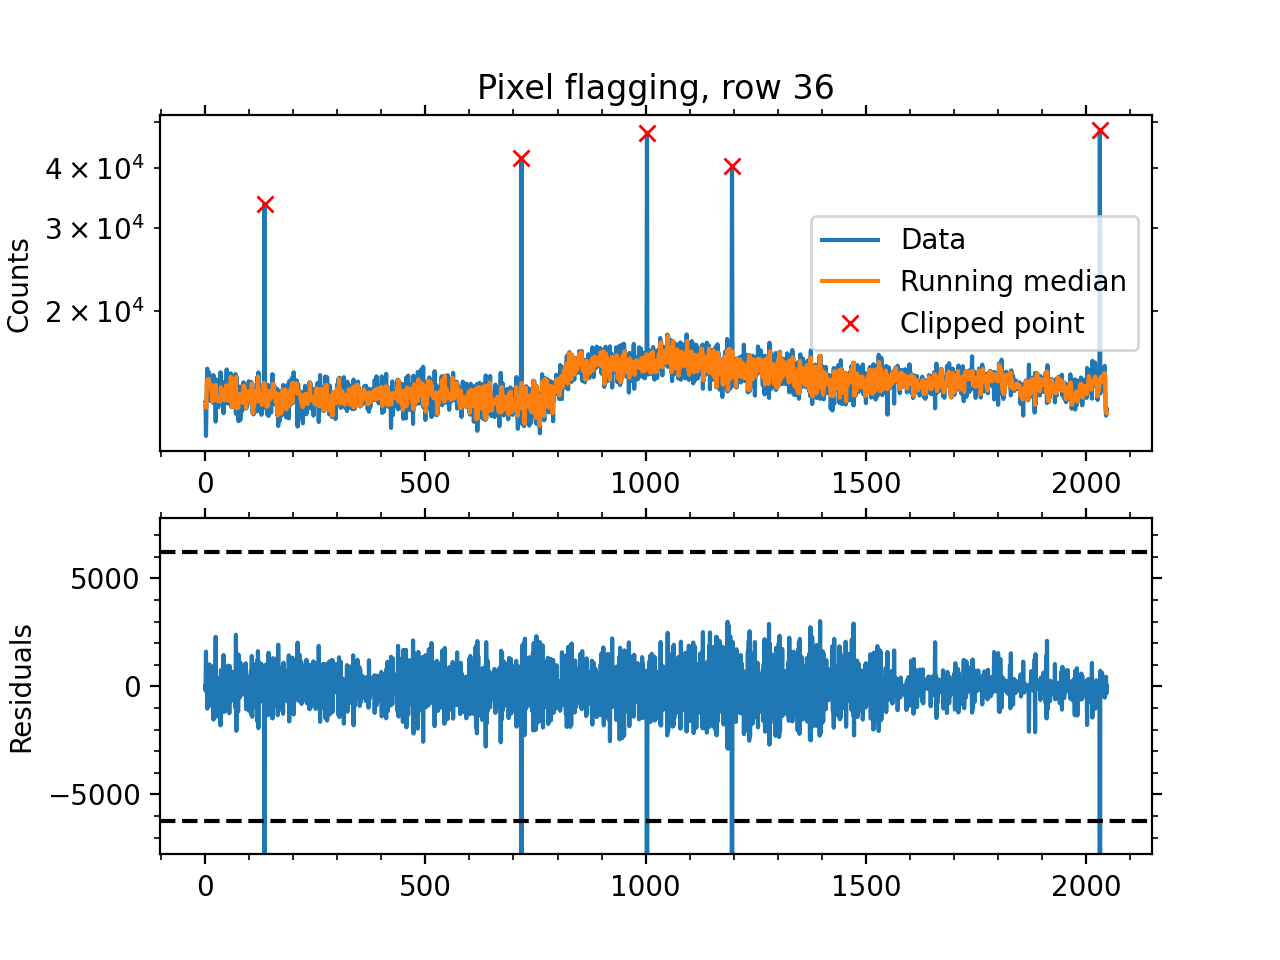

<IPython.core.display.Javascript object>


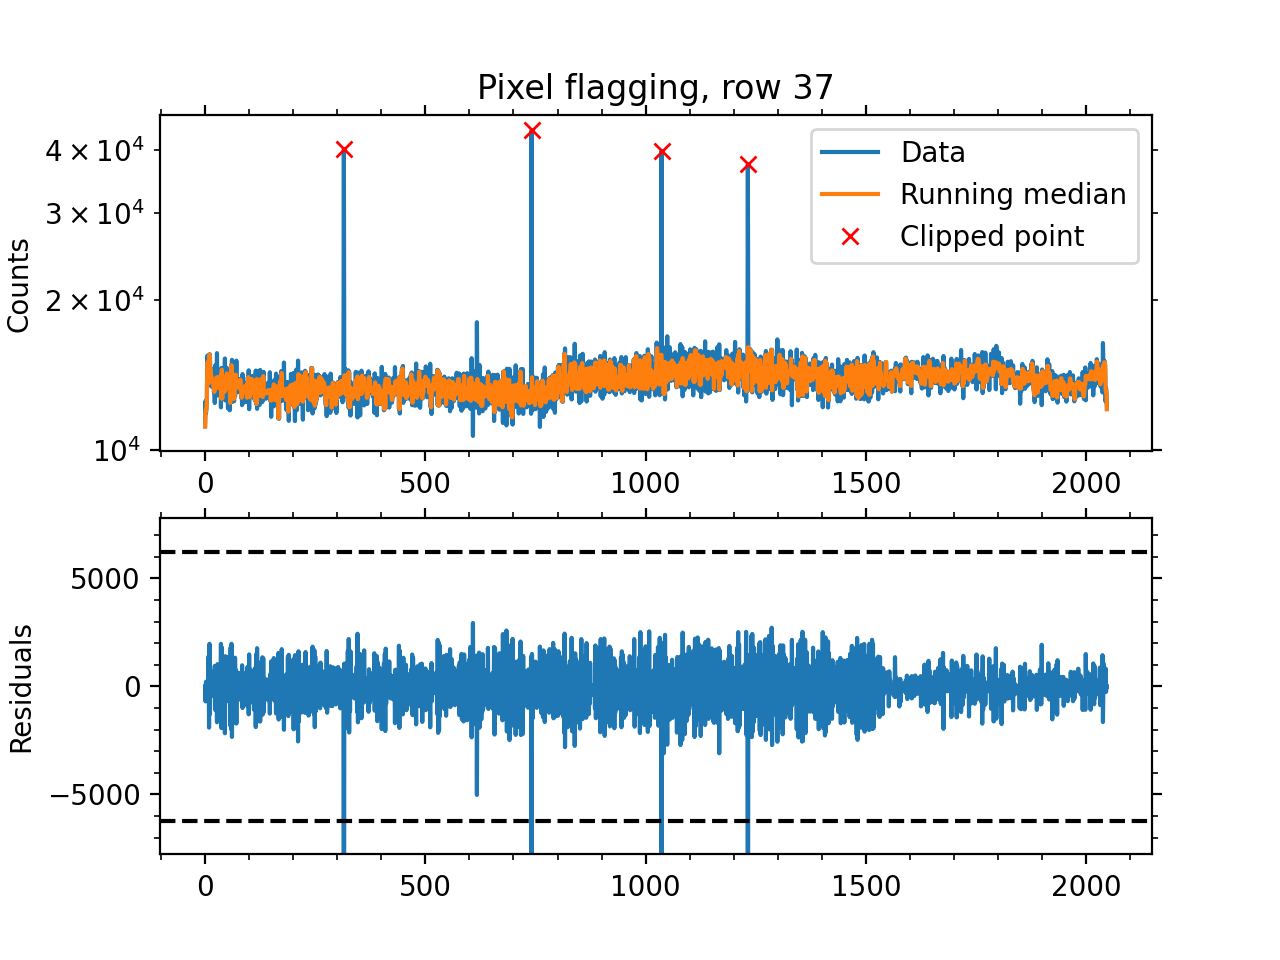

<IPython.core.display.Javascript object>


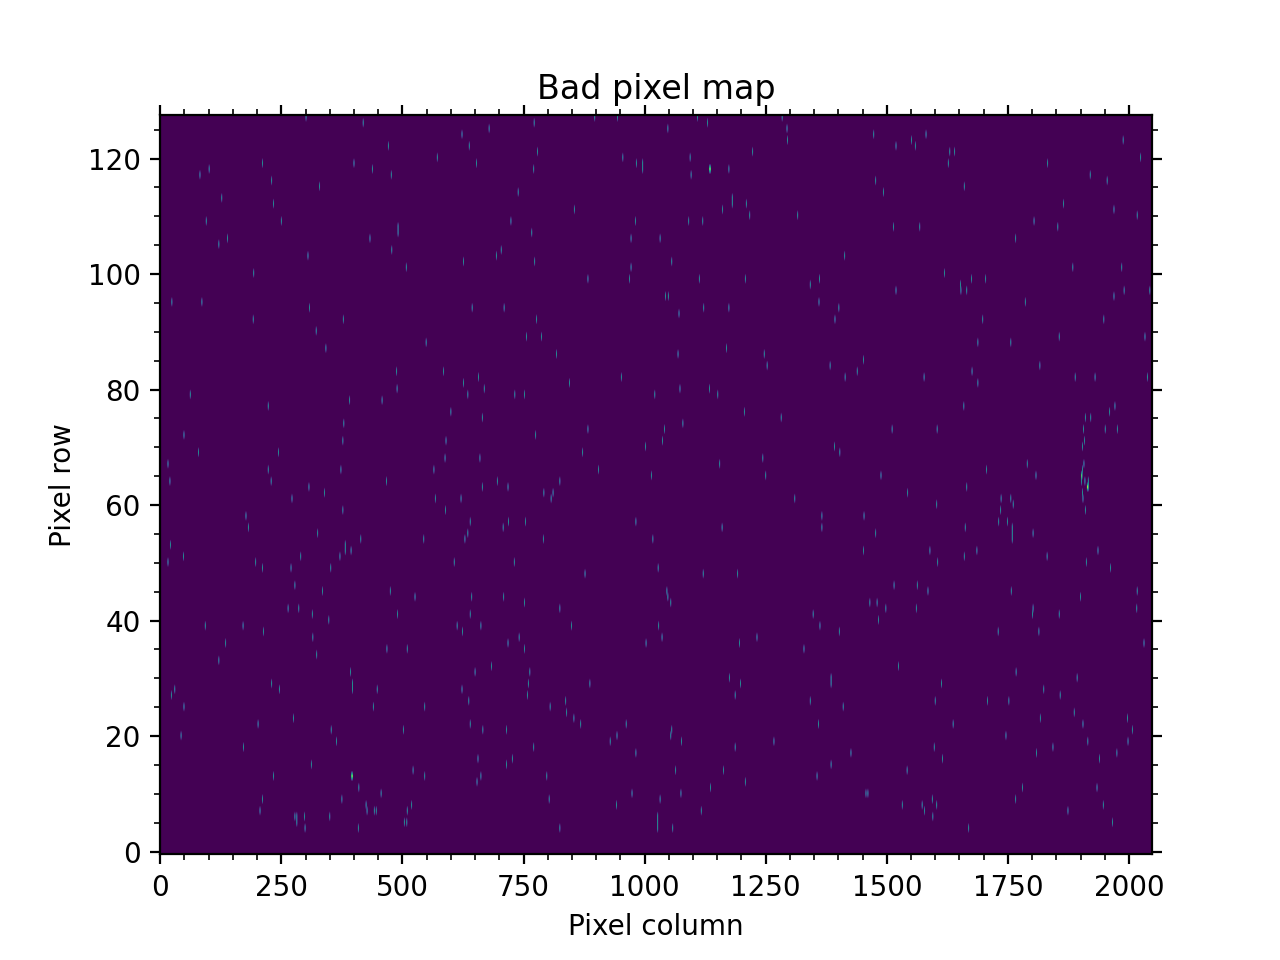

<IPython.core.display.Javascript object>


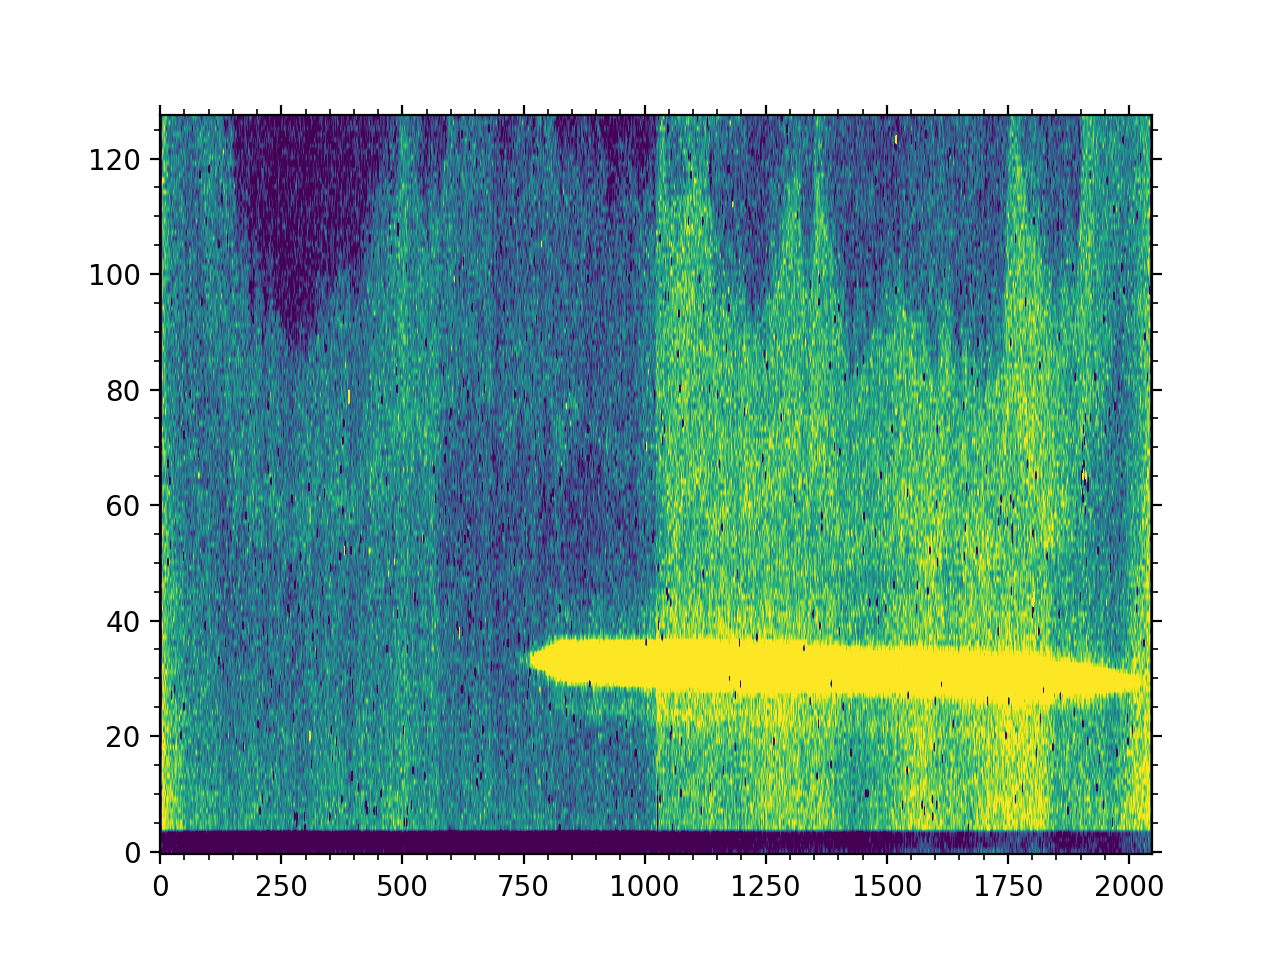

In [16]:
import imp
imp.reload(c)

n1_mask = c.flag_bad_pixels(n1_science,verbose=True,plot_rows=range(26,38),mf_box_width=3,cut_off=4,use_mad=False,\
                           max_pixels_per_row = 20)

# manually flagging additional pixels
n1_mask[27,1544] = True
n1_mask[38,616] = True

n1_science_masked = n1_science.copy()
n1_science_masked[n1_mask] = 0

vmin,vmax = np.percentile(n1_science_masked,[10,90])

plt.figure()
plt.imshow(n1_science_masked,aspect="auto",vmin=vmin,vmax=vmax)
plt.show()

OK, this pixel map looks to have done a decent job. This is the first time whereby I calculated the standard deviation across the full image residuals, not row-by-row which I think helped flag additional bad pixels.

In [17]:
n1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2023-03-10T22:07:47.540' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw01981031001_04103_00001-seg001_nrcalong_uncal.fits' / Name of the f
SDP_VER = '2022_5a '           / Data processing software version number        
PRD_VER = 'PRDOPSSOC-060'      / S&OC PRD version number used in data processing
OSS_VER = '008.006.000.000'    / Observatory Scheduling Software (OSS) version n
DATAMODL= 'Level1bModel'    

In [18]:
pickle.dump(n1_mask,open("nircam_bad_pixel_mask.pickle","wb"))

In [19]:
n1_mask.shape

(128, 2048)

In [20]:
n1.info()

Filename: jw01981031001_04103_00001-seg001_nrcalong/jw01981031001_04103_00001-seg001_nrcalong_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     200   ()      
  1  SCI           1 ImageHDU        67   (2048, 128, 3, 380)   uint16   
  2  GROUP         1 BinTableHDU     38   95R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  3  INT_TIMES     1 BinTableHDU     24   380R x 7C   [J, D, D, D, D, D, D]   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [7919B]   


In [21]:
help(fits.PrimaryHDU)

Help on class PrimaryHDU in module astropy.io.fits.hdu.image:

class PrimaryHDU(_ImageBaseHDU)
 |  PrimaryHDU(data=None, header=None, do_not_scale_image_data=False, ignore_blank=False, uint=True, scale_back=None)
 |  
 |  FITS primary HDU class.
 |  
 |  Method resolution order:
 |      PrimaryHDU
 |      _ImageBaseHDU
 |      astropy.io.fits.hdu.base._ValidHDU
 |      astropy.io.fits.hdu.base._BaseHDU
 |      astropy.io.fits.verify._Verify
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data=None, header=None, do_not_scale_image_data=False, ignore_blank=False, uint=True, scale_back=None)
 |      Construct a primary HDU.
 |      
 |      Parameters
 |      ----------
 |      data : array or ``astropy.io.fits.hdu.base.DELAYED``, optional
 |          The data in the HDU.
 |      
 |      header : `~astropy.io.fits.Header`, optional
 |          The header to be used (as a template).  If ``header`` is `None`, a
 |          minimal header will be provided.
 | 

In [22]:
def save_new_fits(data,filename):
    # make dummy header
    new_header = fits.Header()
    new_header["int_mid_BJD_TDB"] = 0
    new_header["TGROUP"] = 0
    
    # make science extension
    hdu1 = fits.PrimaryHDU([data],header=new_header) # science array
    hdu1.name = "SCI"
    
    # make dummy error extension
    hdu2 = fits.ImageHDU(np.zeros_like([data]))
    hdu2.name = "ERR"

    # make dummy integration extension
    c3 = fits.Column(name='int_mid_BJD_TDB', array=np.array([0.]), format='K')
    hdu3 = fits.BinTableHDU.from_columns([c3])
    hdu3.name = "INT_TIMES"
    
    hdu = fits.HDUList([hdu1,hdu2,hdu3])
    print("saving %s"%filename)
    hdu.writeto(filename,overwrite=True)
    return hdu

In [23]:
master_uncal_n1 = save_new_fits(n1_science_masked,"jw01981031001_04103_00001-seg001_nrcalong/master_uncal.fits") 

saving jw01981031001_04103_00001-seg001_nrcalong/master_uncal.fits


In [63]:
n1_science_masked.shape

(128, 2048)

### Quick look white light curves

In [24]:
r01 = np.loadtxt("reduction01/white_light.dat")
r02 = np.loadtxt("reduction02/white_light.dat")
r03 = np.loadtxt("reduction03/white_light.dat")

from scipy.ndimage import gaussian_filter

<IPython.core.display.Javascript object>


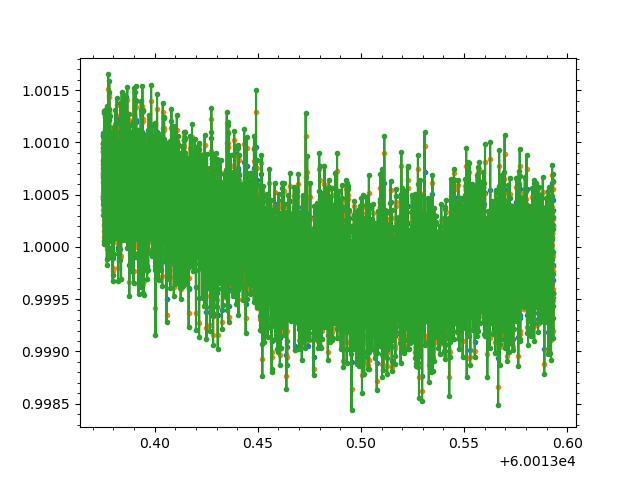

In [26]:
plt.figure()
plt.plot(r01[:,0],r01[:,1]/r01[:,1].mean(),label="reduction01",marker='.')
plt.plot(r02[:,0],r02[:,1]/r02[:,1].mean(),label="reduction02",marker='.')
plt.plot(r03[:,0],r03[:,1]/r03[:,1].mean(),label="reduction03",marker='.')
plt.show()

<IPython.core.display.Javascript object>


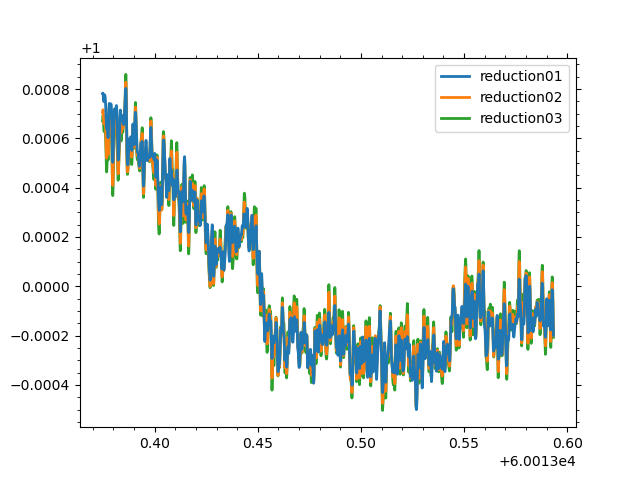

In [37]:
plt.figure()
# plt.plot(r01[:,0],r01[:,1]/r01[:,1].mean(),label="reduction01",marker='.',ls="None")
plt.plot(r01[:,0],gaussian_filter(r01[:,1]/r01[:,1].mean(),sigma=5),label="reduction01",lw=2,zorder=3)
plt.plot(r02[:,0],gaussian_filter(r02[:,1]/r02[:,1].mean(),sigma=5),label="reduction02",lw=2,zorder=2)
plt.plot(r03[:,0],gaussian_filter(r03[:,1]/r03[:,1].mean(),sigma=5),label="reduction03",lw=2,zorder=1)
plt.legend()
# plt.plot(r02[:,0],r02[:,1]/r02[:,1].mean(),label="reduction02",marker='.')
# plt.plot(r03[:,0],r03[:,1]/r03[:,1].mean(),label="reduction03",marker='.')
plt.show()

OK so all reductions give the same red noise but the lowest amplitude is with the narrower ap so this is the way to go, at least with these background assumptions

<IPython.core.display.Javascript object>


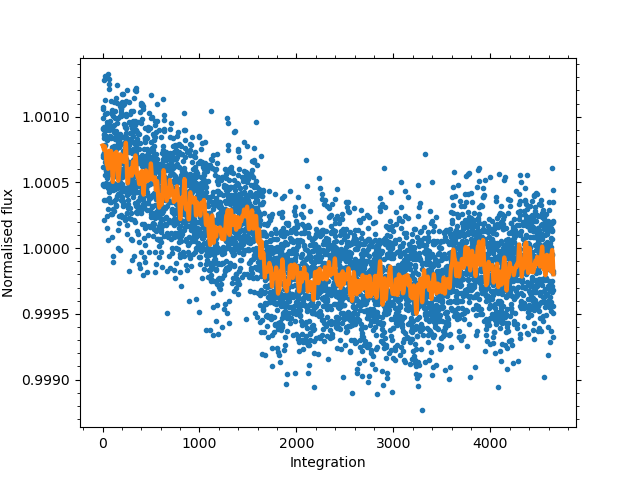

In [41]:
plt.figure()
plt.plot(r01[:,1]/r01[:,1].mean(),label="reduction01",marker='.',ls="None")
plt.plot(gaussian_filter(r01[:,1]/r01[:,1].mean(),sigma=5),label="reduction01",lw=3,zorder=3)
plt.xlabel("Integration")
plt.ylabel("Normalised flux")
plt.show()

In [43]:
r01[:,0]

array([60013.374709, 60013.374756, 60013.374803, ..., 60013.593228,
       60013.593275, 60013.593322])